In [1]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import toml
import glob

# Read config and prepare dataset

In [2]:
config = toml.load('config.toml')

In [3]:
save_folder = config['preprocess']['output_folder']
music_data = ''
# print(isinstance(music_data, str))
for data_path in glob.glob(save_folder + '/*.npy'):
    read = np.load(data_path)
    if isinstance(music_data,str):
        music_data = read
    else:
        music_data = np.append(music_data, read, axis=1)

# music_data = np.concatenate(music_data, axis = 1)


In [4]:
normalize = lambda x : (x - x.min()) / (x.max()-x.min())

In [5]:
#normalize the input.
music_data = np.abs(music_data)
music_data = librosa.amplitude_to_db(music_data)
music_data = normalize(music_data)

In [6]:
print(
music_data.max(),
music_data.min()
)

1.0 0.0


In [7]:
# Data hyperparameters
seq_length = 64
window_stride = 2

# Learning hyperparameters
learning_rate = 0.005
batch_size = 120
input_size = music_data.shape[0]
ds_size = music_data.shape[1]

# Generation hyperparameters
temperature = 0.2 # 0.2 - 1 
num_predictions = 120
# prediction_sample_size = 120


# Create the training dataset

In [8]:
music_ds = tf.data.Dataset.from_tensor_slices(music_data.T)
music_ds.element_spec

2022-02-04 22:15:15.483862: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-04 22:15:15.521027: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-04 22:15:15.521224: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-04 22:15:15.521907: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

TensorSpec(shape=(1025,), dtype=tf.float32, name=None)

In [9]:
def create_training_sequences(dataset: tf.data.Dataset, seq_length: int) -> tf.data.Dataset:
    """Create training sequences and respective labels for training."""
    seq_length += 1
    # Take 1 extra for the labels
    windows = dataset.window(seq_length, shift=1, stride=window_stride,
                                drop_remainder=True)
    # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)


    # Split the labels
    def split_labels(sequences):
        inputs = sequences[:-1]
        target = sequences[-1]
        return inputs, target

    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)



In [10]:
seq_ds = create_training_sequences(music_ds, seq_length)
seq_ds.element_spec

(TensorSpec(shape=(64, 1025), dtype=tf.float32, name=None),
 TensorSpec(shape=(1025,), dtype=tf.float32, name=None))

In [11]:
buffer_size = ds_size - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE)
            )



In [12]:
train_ds.element_spec

(TensorSpec(shape=(120, 64, 1025), dtype=tf.float32, name=None),
 TensorSpec(shape=(120, 1025), dtype=tf.float32, name=None))

# Create and train the model.

In [20]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [32]:

# halved_inputsize = int(input_size * 0.5)
input_shape = (seq_length, input_size)

# Convolutional+Encoder Layer
encoder_inputs = tf.keras.Input(shape = input_shape)
x = tf.keras.layers.Dropout(0.8)(encoder_inputs)

def conv_layers(c_input,times=5, kernel_size=3):
    def _layer(step):
        return tf.keras.layers.DepthwiseConv1D(kernel_size)
    return tf.keras.Sequential([_layer(x) for x in range(times)])(c_input)

x = conv_layers(x,times=2)
x = tf.keras.layers.MaxPool1D(
    pool_size=2, strides=None, padding='valid',
    data_format='channels_last'
)(x)

# Encoder Layer
GRU_output = 1025
seq_e, encoder_state = tf.keras.layers.GRU(
    GRU_output,
    return_state=True,
    return_sequences=True,
)(x)

encoder_outputs = {
    'encoder_state' : encoder_state,
    'encoder_sequence' : seq_e,
}
encoder_loss = {
    'encoder_state' : tf.keras.losses.BinaryCrossentropy(from_logits=True),
    'encoder_sequence' : tf.keras.losses.BinaryCrossentropy(from_logits=True),
}

encoder = tf.keras.Model(encoder_inputs, encoder_outputs)
encoder.compile(loss=encoder_loss, optimizer=optimizer)

del encoder_inputs
del encoder_outputs
del x
encoder.summary()
# print(encoder.outputs)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 64, 1025)]        0         
                                                                 
 dropout_4 (Dropout)         (None, 64, 1025)          0         
                                                                 
 sequential_4 (Sequential)   (None, 60, 1025)          8200      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 30, 1025)         0         
 1D)                                                             
                                                                 
 gru_8 (GRU)                 [(None, 30, 1025),        6309900   
                              (None, 1025)]                      
                                                                 
Total params: 6,318,100
Trainable params: 6,318,100
Non-tr

In [33]:

# Decoder Layer
# del sqe, sm, x
e_st = tf.keras.Input(shape = (30, GRU_output))
e_sq = tf.keras.Input(shape = (GRU_output))


attention_unit = 1025
att = tf.keras.layers.Dense(attention_unit, activation='sigmoid')( e_st)


x = tf.keras.layers.GRU(
    GRU_output,
    # return_sequences=True,
)(att, initial_state=e_sq)

decoder_output = tf.keras.layers.Dense(1025, activation='sigmoid')(x)

decoder = tf.keras.Model([e_st, e_sq], decoder_output)
decoder.compile(loss=loss, optimizer=optimizer)
decoder.summary()


Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 30, 1025)]   0           []                               
                                                                                                  
 dense_8 (Dense)                (None, 30, 1025)     1051650     ['input_17[0][0]']               
                                                                                                  
 input_18 (InputLayer)          [(None, 1025)]       0           []                               
                                                                                                  
 gru_9 (GRU)                    (None, 1025)         6309900     ['dense_8[0][0]',                
                                                                  'input_18[0][0]']        

In [41]:
i = tf.keras.Input(shape = input_shape)
x = encoder(i)
o = decoder([x['encoder_sequence'],x['encoder_state']])
model = tf.keras.Model(i, o)
model.compile(loss=loss, optimizer=optimizer)
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 64, 1025)]   0           []                               
                                                                                                  
 model_10 (Functional)          {'encoder_state': (  6318100     ['input_22[0][0]']               
                                None, 1025),                                                      
                                 'encoder_sequence'                                               
                                : (None, 30, 1025)}                                               
                                                                                                  
 model_11 (Functional)          (None, 1025)         8413200     ['model_10[3][0]',        

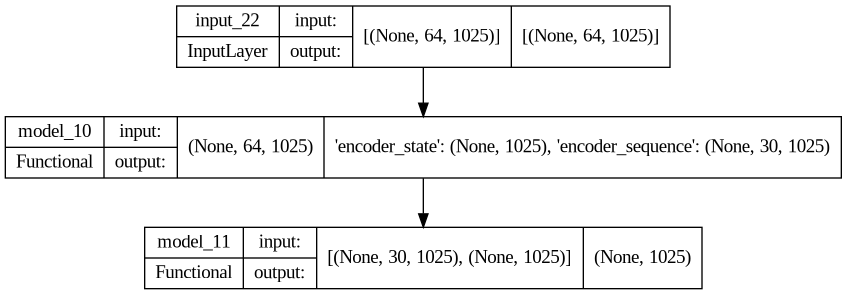

In [42]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [43]:
losses = model.evaluate(train_ds, return_dict=True)

2022-02-04 22:29:31.153826: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8301


92/92 [==============================] - 9s 71ms/step - loss: 0.1137


In [44]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]


In [45]:
%%time
epochs = 5

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)


Epoch 1/5
92/92 [==============================] - 19s 183ms/step - loss: 2.0896
Epoch 2/5
92/92 [==============================] - 17s 180ms/step - loss: 0.0184
Epoch 3/5
92/92 [==============================] - 17s 180ms/step - loss: 0.0178
Epoch 4/5
92/92 [==============================] - 17s 182ms/step - loss: 0.0178
Epoch 5/5
92/92 [==============================] - 16s 178ms/step - loss: 0.0183
CPU times: user 1min 22s, sys: 965 ms, total: 1min 23s
Wall time: 1min 24s


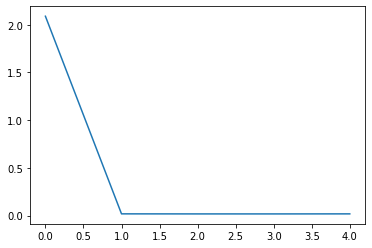

In [46]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [47]:
model.input_shape

(None, 64, 1025)

In [48]:
model.outputs

[<KerasTensor: shape=(None, 1025) dtype=float32 (created by layer 'model_11')>]

In [49]:
model.save('model')

2022-02-04 22:31:19.433537: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [50]:
def predict_next(
    inputs: np.ndarray, 
    keras_model: tf.keras.Model, 
    ) -> np.ndarray:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(inputs, 0)
  # random = tf.random.normal(inputs.shape)
  # inputs = inputs * random
  predictions = model.predict(inputs)
  # predictions = inverse_normalization(predictions)
  return predictions


In [51]:
import random

note_start = random.randint(0, len(music_data.T)-seq_length-1)
sample = music_data[:,note_start:note_start+seq_length].T

generated_notes = []

for i in range(num_predictions):
    prediction = predict_next(sample, model)
    generated_notes.append(prediction)
    sample = np.delete(sample, 0, axis=0)
    sample = np.append(sample, prediction, axis=0)
generated_notes = np.concatenate(generated_notes)

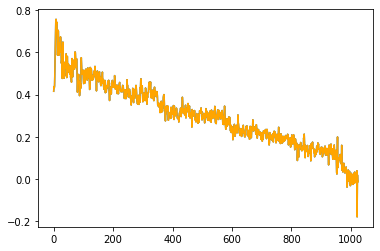

In [52]:
plt.plot(generated_notes[21])
plt.plot(generated_notes[25],color='orange')

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

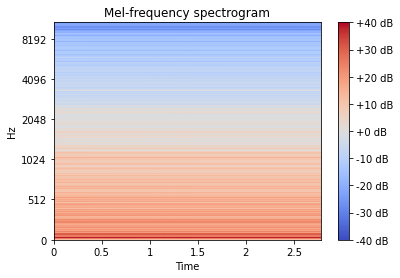

In [53]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
generated_notes = normalize(generated_notes) * 80 - 40


# print(generated_notes.min())

img = librosa.display.specshow(generated_notes.T, x_axis='time',

                         y_axis='mel', sr=22050,

                        ax=ax)

fig.colorbar(img, ax=ax, format='%+2.0f dB')

ax.set(title='Mel-frequency spectrogram')


In [54]:
import librosa.feature
if config['preprocess']['feature_extraction'] == 'mel':
    A = librosa.feature.inverse.mel_to_audio(generated_notes)
elif config['preprocess']['feature_extraction'] == 'mfcc':
    A = librosa.feature.inverse.mfcc_to_audio(generated_notes)
elif config['preprocess']['feature_extraction'] == 'stft':
    A = librosa.griffinlim(generated_notes)

In [55]:
import IPython.display as ipd
ipd.Audio(A, rate=22050)